### Train a ALM in Google Colab!

### Clone the repository if you don't have it already

In [1]:
import os

if not os.path.isdir('nanoALM'):
    !git clone https://github.com/LWL220184016/nanoVLM_From_Huggingface.git
%cd nanoVLM_From_Huggingface/
!ls

fatal: destination path 'nanoVLM_From_Huggingface' already exists and is not an empty directory.
/content/nanoVLM_From_Huggingface
 assets					   'download (2).png'
 benchmark-inference.py			    generate.py
 benchmark_suite.py			    measure_vram.py
 checkpoints				    models
 data					    nanoALM.ipynb
 debug_func.py				    README.md
 debug_tokenizer_dataset_compatibility.py   train.py


### Imports and Setup

In [2]:
# Let's authentificate with the Hugging Face Hub so you can push your model
# from huggingface_hub import notebook_login
# notebook_login()
# !huggingface-cli login

In [3]:
# If you get an "Error" from pip's dependency resolver but the cell complets fine, this is not an issue, you can continue :)
!pip -q install torch
!pip -q install gcsfs
!pip -q install tqdm
!pip -q install huggingface_hub
!pip -q install librosa
!pip install --upgrade datasets
!pip install --upgrade transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [4]:
# Decide on the name of your model here!
# You will need your HF user name and the name you want to give to it
# For me, this would be "lusxvr/nanoALM"
# hf_model_name = "YOUR_HF_USER_NAME/nanoALM"

In [5]:
# nanoALM Imports (please check out the implementations in detail, that's where all the interessting stuff is!)
from data.collators import AudioQACollator, SAVEECollator
from data.datasets import SAVEEDataset, AudioQADataset
from data.processors import get_audio_processor
from data.processors import get_tokenizer
from models.audio_language_model import AudioLanguageModel
import models.utils as utils

# Libraries
import math
import time
import torch
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets

#Otherwise, the tokenizer will through a warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.autograd.set_detect_anomaly(True)

if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
trained_model = None

# To reload the modules if you change something in the code
%reload_ext autoreload
%autoreload 2

Using device: cuda


### Get the dataloaders

In [6]:
def get_dataloaders(train_cfg, alm_cfg):
    # Create datasets
    audio_processor = get_audio_processor(alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # text = "splitting datasets, disable in get_dataloaders function"
    # print(f"\n\033[38;5;05m{text}05m\033[0m")
    # Load and combine all training datasets
    combined_train_data = []
    for dataset_name in train_cfg.train_dataset_name:
        train_ds = load_dataset(
        path = train_cfg.train_dataset_path,
        name = dataset_name,
    )
        combined_train_data.append(train_ds['train'])
    train_ds = concatenate_datasets(combined_train_data)

    test_ds = load_dataset(train_cfg.test_dataset_path)
    train_ds = train_ds.shuffle(seed=0) # Shuffle the training dataset, so train and val get equal contributions from all concatinated datasets

    # Apply cutoff if specified
    if train_cfg.data_cutoff_idx is None:
        total_samples = len(train_ds)  # Use the entire dataset
    else:
        total_samples = min(len(train_ds), train_cfg.data_cutoff_idx)

    val_size = int(total_samples * train_cfg.val_ratio)
    train_size = total_samples - val_size

    train_dataset = AudioQADataset(train_ds.select(range(train_size)), tokenizer, audio_processor)
    val_dataset = AudioQADataset(train_ds.select(range(train_size, total_samples)), tokenizer, audio_processor)
    test_dataset = SAVEEDataset(test_ds, tokenizer, audio_processor)

    # Create collators
    aqa_collator = AudioQACollator(tokenizer, alm_cfg.lm_max_length)
    savee_collator = SAVEECollator(tokenizer)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=True,
        collate_fn=aqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=False,
        collate_fn=aqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=train_cfg.savee_batch_size,
        shuffle=False,
        collate_fn=savee_collator,
        pin_memory=True,
        )

    return train_loader, val_loader, test_loader

### Prepare the testing function

In [7]:
def test_savee(model, tokenizer, test_loader, device):
    total_examples = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in test_loader:
            audio = batch['audios'].to(device)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            correct_answer = tokenizer.batch_decode(labels, skip_special_tokens=True)

            gen = model.generate(input_ids, audio, attention_mask)
            model_output = tokenizer.batch_decode(gen, skip_special_tokens=True)

            is_correct = utils.check_multiple_choice_with_regex(model_output, correct_answer)

            total_examples += len(is_correct)
            if is_correct:
                correct_predictions += sum(is_correct)
    accuracy = correct_predictions / total_examples if total_examples > 0 else 0
    return accuracy

### Add debug

In [8]:
# 在训练开始前添加这个检查函数
def debug_model_dimensions(model, input_ids, audio):
    """调试模型各层的维度"""
    print("=== Model Dimension Debug ===")

    # 检查音频编码器
    audio_features = model.audio_encoder.forward(audio, output_hidden_states=True)
    print(f"Audio features shape: {audio_features.shape}")

    # 检查模态投影器
    audio_embeds = model.MP(audio_features)
    print(f"Audio embeds shape: {audio_embeds.shape}")

    # 检查文本嵌入
    text_embeds = model.decoder.token_embedding(input_ids)
    print(f"Text embeds shape: {text_embeds.shape}")

    # 检查拼接后的嵌入
    inputs_embeds = torch.cat([audio_embeds, text_embeds], dim=1)
    print(f"Combined embeds shape: {inputs_embeds.shape}")

    # 检查语言模型输出
    logits = model.decoder(inputs_embeds)
    print(f"Logits shape: {logits.shape}")
    print(f"Vocab size (last dim): {logits.shape[-1]}")

    # 检查语言模型配置
    print(f"LM vocab size config: {model.cfg.lm_vocab_size}")
    print(f"Decoder vocab size: {getattr(model.decoder, 'vocab_size', 'Not found')}")

    return logits.shape[-1]

# 在训练循环开始前调用
# vocab_size = debug_model_dimensions(model, input_ids, audios)

In [9]:
def debug_training_step(model, input_ids, audios, attention_mask, labels):
    """调试训练步骤"""
    # 添加这些调试行：
    print(f"Batch debug - input_ids shape: {input_ids.shape}, max: {input_ids.max().item()}")
    print(f"Batch debug - labels shape: {labels.shape}, max: {labels.max().item()}")
    print(f"Batch debug - Model vocab config: {model.cfg.lm_vocab_size}")

    # 检查decoder的实际vocab_size
    if hasattr(model.decoder, 'head') and hasattr(model.decoder.head, 'out_features'):
        print(f"Decoder head in_features: {model.decoder.head.in_features}")
        print(f"Decoder head out_features: {model.decoder.head.out_features}")

### Prepare the training loop

#### Supervised learning and Generative Training 監督學習生成式訓練

In [10]:
def get_lr(it, max_lr, max_steps):
    min_lr = max_lr * 0.1
    warmup_steps = max_steps * 0.03
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

def train(train_cfg, alm_cfg):
    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # Initialize model
    if train_cfg.resume_from_alm_checkpoint:
        model = AudioLanguageModel.from_pretrained(alm_cfg.alm_checkpoint_path)
    else:
        model = AudioLanguageModel(alm_cfg)

    print(f"nanoALM initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
    print(f"Training summary: {len(train_loader.dataset)} samples, {len(train_loader)} batches/epoch, batch size {train_cfg.batch_size}")

    # Define optimizer groups
    param_groups = [{'params': model.MP.parameters(), 'lr': train_cfg.lr_mp},
                    {'params': list(model.decoder.parameters()) + list(model.audio_encoder.parameters()), 'lr': train_cfg.lr_backbones}]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    epoch_times = []
    batch_losses = []
    val_losses = []
    val_plot_steps = []
    best_accuracy = 0
    global_step = 0
    for epoch in range(train_cfg.epochs):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        total_tokens_processed = 0

        for batch in tqdm(train_loader):
            batch_start_time = time.time()
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # debug_model_dimensions(model, input_ids, audios)  # Debug model dimensions with dummy data
            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16): # Mixed precision training
                # debug_training_step(model, input_ids, audios, attention_mask, labels)  # Debug training step
                _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            loss.backward()

            adj_lr_mp = get_lr(global_step, train_cfg.lr_mp, len(train_loader) * train_cfg.epochs)
            adj_lr_backbones = get_lr(global_step, train_cfg.lr_backbones, len(train_loader) * train_cfg.epochs)
            optimizer.param_groups[0]['lr'] = adj_lr_mp
            optimizer.param_groups[1]['lr'] = adj_lr_backbones

            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            num_tokens = torch.sum(attention_mask).item()
            # 修改音頻token計算：根據實際的音頻處理方式
            audio_tokens = audios.shape[0] * alm_cfg.mp_target_length  # 使用配置的目標長度
            num_tokens += audio_tokens
            total_tokens_processed += num_tokens

            batch_end_time = time.time()
            batch_duration = batch_end_time - batch_start_time
            tokens_per_second = num_tokens / batch_duration

            if global_step % 5 == 0:
                model.eval()
                torch.cuda.empty_cache()  # Clear GPU memory
                with torch.no_grad():
                    total_val_loss = 0
                    for batch in val_loader:
                        audios = batch["audio"].to(device)
                        input_ids = batch["input_ids"].to(device)
                        labels = batch["labels"].to(device)
                        attention_mask = batch["attention_mask"].to(device)

                        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                            # debug_training_step(model, input_ids, audios, attention_mask, labels)  # Debug training step
                            _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

                        total_val_loss += loss.item()
                    avg_val_loss = total_val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)
                    val_plot_steps.append(global_step)
                epoch_accuracy = 0
                if train_cfg.eval_in_epochs:
                    epoch_accuracy = test_savee(model, tokenizer, test_loader, device)
                    if epoch_accuracy > best_accuracy:
                      best_accuracy = epoch_accuracy
                      model.save_pretrained(save_directory=alm_cfg.alm_checkpoint_path)
                    print(f"\nStep: {global_step}, Loss: {batch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Tokens/s: {tokens_per_second:.2f}, Accuracy: {epoch_accuracy:.4f}")
                model.train()

            global_step += 1

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        epoch_tokens_per_second = total_tokens_processed / epoch_duration

        print(f"Epoch {epoch+1}/{train_cfg.epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {epoch_duration:.2f}s | T/s: {epoch_tokens_per_second:.2f}")

    # Summary Statistics
    if not train_cfg.eval_in_epochs:
        model.save_pretrained(save_directory=alm_cfg.alm_checkpoint_path)
    try:
        model.push_to_hub(hf_model_name)
    except Exception as e:
        print(f"Error pushing model to hub: {e}")

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    total_training_time = sum(epoch_times)
    total_samples_processed = len(train_loader.dataset) * train_cfg.epochs
    avg_time_per_sample = total_training_time / total_samples_processed
    print(f"Average time per epoch: {avg_epoch_time:.2f}s")
    print(f"Average time per sample: {avg_time_per_sample:.4f}s")

    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    return model

    # With this code you can test the accuracy of the model on the SAVEE dataset
    # But if you only train with few samples, the accuracy will be very low
    # print("Testing SAVEE Accuracy:")
    # accuracy = test_savee(model, tokenizer, test_loader, device)
    # print(f"SAVEE Accuracy: {accuracy:.4f}")

#### Three-stage training (contrast training, generative training, instruction fine-tuning) 三段式訓練(對比訓練, 生成式訓練, 指令微調)

In [11]:
import torch.nn.functional as F
import torch.nn as nn

def contrastive_loss(audio_embeds, text_embeds, temperature=0.07):
    """对比学习损失"""
    # 池化到固定维度
    audio_pooled = audio_embeds.mean(dim=1)  # [B, hidden_dim]
    text_pooled = text_embeds.mean(dim=1)    # [B, hidden_dim]

    # 归一化
    audio_pooled = F.normalize(audio_pooled, dim=-1)
    text_pooled = F.normalize(text_pooled, dim=-1)

    # 计算相似度矩阵
    logits = torch.matmul(audio_pooled, text_pooled.T) / temperature

    # 对角线为正样本
    labels = torch.arange(logits.size(0)).to(logits.device)

    # 双向对比损失
    loss_a2t = F.cross_entropy(logits, labels)
    loss_t2a = F.cross_entropy(logits.T, labels)

    return (loss_a2t + loss_t2a) / 2

def stable_contrastive_loss(audio_embeds, text_embeds, temperature=0.1):
    """更稳定的对比学习损失"""
    # 使用多种池化策略的组合
    batch_size = audio_embeds.shape[0]

    # 1. 均值池化
    audio_mean = audio_embeds.mean(dim=1)
    text_mean = text_embeds.mean(dim=1)

    # 2. 最大池化
    audio_max = audio_embeds.max(dim=1)[0]
    text_max = text_embeds.max(dim=1)[0]

    # 3. 加权池化（使用注意力权重）
    audio_weights = F.softmax(audio_embeds.sum(dim=-1), dim=1).unsqueeze(-1)
    audio_weighted = (audio_embeds * audio_weights).sum(dim=1)

    text_weights = F.softmax(text_embeds.sum(dim=-1), dim=1).unsqueeze(-1)
    text_weighted = (text_embeds * text_weights).sum(dim=1)

    # 组合特征
    audio_pooled = torch.cat([audio_mean, audio_max, audio_weighted], dim=-1)
    text_pooled = torch.cat([text_mean, text_max, text_weighted], dim=-1)

    # L2归一化
    audio_pooled = F.normalize(audio_pooled, p=2, dim=-1)
    text_pooled = F.normalize(text_pooled, p=2, dim=-1)

    # 计算相似度矩阵
    sim_matrix = torch.matmul(audio_pooled, text_pooled.T) / temperature

    # 标签
    labels = torch.arange(batch_size).to(sim_matrix.device)

    # 对称对比损失
    loss_a2t = F.cross_entropy(sim_matrix, labels, label_smoothing=0.1)
    loss_t2a = F.cross_entropy(sim_matrix.T, labels, label_smoothing=0.1)

    # 添加特征多样性正则化
    diversity_loss = -torch.mean(torch.var(audio_pooled, dim=0)) - torch.mean(torch.var(text_pooled, dim=0))

    total_loss = (loss_a2t + loss_t2a) / 2 + 0.01 * diversity_loss

    return total_loss

def train_step1_alignment(train_cfg, alm_cfg):
    """第一步：模态投影器对齐训练（包含预训练阶段）"""
    print("=== Stage 1: Modality Projector Alignment (with Pretraining) ===")

    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    model = AudioLanguageModel(alm_cfg)

    # 冻结参数
    for param in model.audio_encoder.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = False

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # =================== Stage 0.5: MP预训练 ===================
    print("--- Stage 0.5: MP Pretraining with Reconstruction Loss ---")

    # 预训练优化器（使用较高学习率）
    pretrain_optimizer = optim.AdamW(model.MP.parameters(), lr=train_cfg.lr_mp * 2)

    for epoch in range(6):  # 预训练3个epoch
        model.train()
        total_pretrain_loss = 0

        for batch in tqdm(train_loader, desc=f"MP Pretrain Epoch {epoch+1}"):
            audios = batch["audio"].to(device)

            pretrain_optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                # 获取音频特征
                input_features = audios.to(device)
                with torch.no_grad():
                    encoder_outputs = model.audio_encoder.encoder(input_features, output_hidden_states=True)

                audio_features = encoder_outputs.last_hidden_state  # [B, T, D]

                # 通过MP投影
                audio_embeds = model.MP(audio_features)  # [B, target_length, lm_hidden_dim]

                # 创建重构目标：将原始特征池化到目标长度
                # 方法1：自适应平均池化
                target_features = F.adaptive_avg_pool1d(
                    audio_features.transpose(1, 2),  # [B, D, T]
                    audio_embeds.shape[1]  # target_length
                ).transpose(1, 2)  # [B, target_length, D]

                # 通过线性层调整维度匹配
                if not hasattr(model, 'pretrain_proj'):
                    model.pretrain_proj = nn.Linear(
                        audio_features.shape[-1],
                        audio_embeds.shape[-1]
                    ).to(device)

                target_embeds = model.pretrain_proj(target_features)

                # MSE重构损失
                recon_loss = F.mse_loss(audio_embeds, target_embeds)

            recon_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.MP.parameters(), max_norm=1.0)
            pretrain_optimizer.step()

            total_pretrain_loss += recon_loss.item()

        avg_pretrain_loss = total_pretrain_loss / len(train_loader)
        print(f"MP Pretrain Epoch {epoch+1}: Reconstruction Loss {avg_pretrain_loss:.4f}")

    print("MP Pretraining completed! Starting contrastive learning...")

    # =================== Stage 1: 对比学习 ===================

    # 对比学习优化器（使用较低学习率）
    optimizer = optim.AdamW(model.MP.parameters(), lr=train_cfg.lr_mp * 0.5, weight_decay=0.01)

    # 学习率调度器
    total_steps = len(train_loader) * train_cfg.stage1_epochs
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=train_cfg.lr_mp * 0.5,
        total_steps=total_steps,
        pct_start=0.1,
        anneal_strategy='cos'
    )

    batch_losses = []
    best_loss = float('inf')
    global_step = 0

    for epoch in range(train_cfg.stage1_epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Stage1 Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                # 音频编码
                input_features = audios.to(device)
                with torch.no_grad():
                    encoder_outputs = model.audio_encoder.encoder(input_features, output_hidden_states=True)

                audio_features = encoder_outputs.last_hidden_state
                audio_embeds = model.MP(audio_features)

                # 文本编码
                text_embeds = model.decoder.token_embedding(input_ids[:, :-1])

                # 对比学习损失
                loss = stable_contrastive_loss(audio_embeds, text_embeds)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.MP.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            if global_step % 100 == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Step {global_step}: Loss {batch_loss:.4f}, LR {current_lr:.2e}")

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Stage1 Epoch {epoch+1}: Contrastive Loss {avg_train_loss:.4f}")

        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage1_best")

    # 清理预训练用的临时层
    if hasattr(model, 'pretrain_proj'):
        delattr(model, 'pretrain_proj')

    model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage1_final")
    print("Stage 1 completed!")

    # 绘制损失曲线
    plt.plot(batch_losses, label='Contrastive Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Stage 1: Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    return model

def train_step2_pretraining(train_cfg, alm_cfg, stage1_model=None):
    """第二步：语言模型预训练"""
    print("=== Stage 2: Language Model Pretraining ===")

    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # 加载第一阶段模型或从头开始
    if stage1_model is not None:
        model = stage1_model
    else:
        try:
            model = AudioLanguageModel.from_pretrained(f"{alm_cfg.alm_checkpoint_path}/stage1_final")
            print("Loaded Stage 1 model")
        except:
            model = AudioLanguageModel(alm_cfg)
            print("Starting Stage 2 from scratch")

    # 冻结音频编码器，解冻语言模型和模态投影器
    for param in model.audio_encoder.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = True
    for param in model.MP.parameters():
        param.requires_grad = True

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Stage 2: Training {trainable_params:,} parameters")

    # 不同学习率
    param_groups = [
        {'params': model.MP.parameters(), 'lr': train_cfg.lr_mp * 0.1},
        {'params': model.decoder.parameters(), 'lr': train_cfg.lr_backbones}
    ]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    batch_losses = []
    val_losses = []
    val_plot_steps = []
    best_loss = float('inf')
    global_step = 0

    for epoch in range(train_cfg.stage2_epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Stage2 Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                # 使用因果语言建模损失
                _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            loss.backward()

            # 动态学习率调整
            adj_lr_mp = get_lr(global_step, train_cfg.lr_mp * 0.1, len(train_loader) * train_cfg.stage2_epochs)
            adj_lr_backbones = get_lr(global_step, train_cfg.lr_backbones, len(train_loader) * train_cfg.stage2_epochs)
            optimizer.param_groups[0]['lr'] = adj_lr_mp
            optimizer.param_groups[1]['lr'] = adj_lr_backbones

            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage2_best")

    # 保存第二阶段模型
    model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage2_final")
    print("Stage 2 completed!")
    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    return model

def train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model=None):
    """第三步：指令微调"""
    print("=== Stage 3: Instruction Tuning ===")

    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # 加载第二阶段模型
    if stage2_model is not None:
        model = stage2_model
    else:
        try:
            model = AudioLanguageModel.from_pretrained(f"{alm_cfg.alm_checkpoint_path}/stage2_final")
            print("Loaded Stage 2 model")
        except:
            print("No Stage 2 model found, using current model")
            model = AudioLanguageModel(alm_cfg)

    # 全部解冻，使用较小学习率
    for param in model.parameters():
        param.requires_grad = True

    print(f"Stage 3: Training all {sum(p.numel() for p in model.parameters()):,} parameters")

    # 更小的学习率
    param_groups = [
        {'params': model.MP.parameters(), 'lr': train_cfg.lr_mp * 0.01},
        {'params': model.decoder.parameters(), 'lr': train_cfg.lr_backbones * 0.1},
        {'params': model.audio_encoder.parameters(), 'lr': train_cfg.lr_backbones * 0.01}
    ]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    # 这里可以使用原来的训练循环，但数据应该是指令格式
    # 暂时使用相同的数据格式
    best_accuracy = 0
    global_step = 0

    for epoch in range(train_cfg.stage3_epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Stage3 Epoch {epoch+1}"):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                _, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)

            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss

            if global_step % 50 == 0:
                print(f"Stage3 Step: {global_step}, Instruction Loss: {batch_loss:.4f}")

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        # 评估性能
        if train_cfg.eval_in_epochs:
            accuracy = test_savee(model, tokenizer, test_loader, device)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage3_best")
            print(f"Stage3 Epoch {epoch+1}/{train_cfg.stage3_epochs} | Loss: {avg_train_loss:.4f} | Accuracy: {accuracy:.4f}")
        else:
            print(f"Stage3 Epoch {epoch+1}/{train_cfg.stage3_epochs} | Instruction Loss: {avg_train_loss:.4f}")

    # 保存最终模型
    model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/final_model")
    print("Stage 3 completed!")
    return model

def train_three_stages(train_cfg, alm_cfg):
    """完整的三阶段训练"""
    print("Starting Three-Stage Training Pipeline")

    # 第一阶段：模态投影器对齐
    stage1_model = train_step1_alignment(train_cfg, alm_cfg)

    # 第二阶段：语言模型预训练
    stage2_model = train_step2_pretraining(train_cfg, alm_cfg, stage1_model)

    # 第三阶段：指令微调
    final_model = train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model)

    print("=== Training Pipeline Completed! ===")
    return stage1_model, stage2_model, final_model


# # 替换原来的训练调用
# alm_cfg = ALMConfig()
# train_cfg = TrainConfig()

# # 运行三阶段训练
# final_model = train_three_stages(train_cfg, alm_cfg)

In [ ]:
# ========== 修复重复token问题的专门函数 ==========

def enhanced_generation_loss(logits, labels, tokenizer, eos_weight=2.0):
    """增强的生成损失，特别强化EOS token"""
    # 标准交叉熵损失
    standard_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), 
                                   labels.view(-1), 
                                   ignore_index=-100)
    
    # EOS token增强损失
    eos_token_id = tokenizer.eos_token_id
    eos_mask = (labels == eos_token_id)
    
    if eos_mask.any():
        eos_logits = logits[eos_mask]
        eos_labels = labels[eos_mask]
        eos_loss = F.cross_entropy(eos_logits, eos_labels)
        
        # 组合损失
        total_loss = standard_loss + eos_weight * eos_loss
    else:
        total_loss = standard_loss
    
    return total_loss

def add_eos_regularization(model, input_ids, tokenizer):
    """添加EOS正则化训练"""
    # 确保训练数据以EOS结尾
    batch_size = input_ids.shape[0]
    eos_token_id = tokenizer.eos_token_id
    
    # 检查是否以EOS结尾，如果没有则添加
    enhanced_input_ids = []
    for i in range(batch_size):
        seq = input_ids[i]
        # 找到非padding部分
        non_pad_mask = seq != tokenizer.pad_token_id
        if non_pad_mask.any():
            non_pad_seq = seq[non_pad_mask]
            if non_pad_seq[-1] != eos_token_id:
                # 添加EOS token
                non_pad_seq = torch.cat([non_pad_seq, torch.tensor([eos_token_id]).to(seq.device)])
            enhanced_input_ids.append(non_pad_seq)
    
    return enhanced_input_ids

def debug_generation_step(model, tokenizer, audio, prompt="What is said in this audio?"):
    """调试生成步骤"""
    print("=== Generation Debug ===")
    
    # 准备输入
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # 单步生成测试
    with torch.no_grad():
        # 获取音频特征
        if hasattr(audio, 'input_features'):
            audio_input = audio.input_features
        else:
            audio_input = audio
            
        audio_features = model.audio_encoder.encoder(audio_input, output_hidden_states=True)
        audio_embeds = model.MP(audio_features.last_hidden_state)
        
        # 文本嵌入
        text_embeds = model.decoder.token_embedding(inputs.input_ids)
        
        # 拼接
        combined_embeds = torch.cat([audio_embeds, text_embeds], dim=1)
        
        # 前向传播
        logits = model.decoder(combined_embeds)
        
        # 分析logits
        last_logits = logits[0, -1, :]  # 最后一个位置的logits
        probs = F.softmax(last_logits, dim=-1)
        
        # 找到top-k最可能的token
        top_k_probs, top_k_indices = torch.topk(probs, k=10)
        
        print("Top 10 next tokens:")
        for i, (prob, idx) in enumerate(zip(top_k_probs, top_k_indices)):
            token = tokenizer.decode([idx])
            print(f"{i+1}. '{token}' (prob: {prob:.4f})")
        
        # 检查是否有重复模式
        repeated_tokens = []
        for i, idx in enumerate(top_k_indices[:5]):
            token = tokenizer.decode([idx])
            if len(token) == 1 and token.isdigit():
                repeated_tokens.append(token)
        
        if repeated_tokens:
            print(f"⚠️  Warning: Found repeated digit tokens: {repeated_tokens}")
        
        # 检查EOS token概率
        eos_prob = probs[tokenizer.eos_token_id]
        print(f"EOS token probability: {eos_prob:.6f}")
        
        if eos_prob < 0.001:
            print("⚠️  Warning: EOS token probability is very low!")

def fixed_generate_function(model, tokenizer, audio, prompt="What is said in this audio?", max_new_tokens=20):
    """修复的生成函数"""
    # 准备输入
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        # 音频处理
        if hasattr(audio, 'input_features'):
            audio_input = audio.input_features
        else:
            audio_input = audio
            
        audio_features = model.audio_encoder.encoder(audio_input, output_hidden_states=True)
        audio_embeds = model.MP(audio_features.last_hidden_state)
        
        # 初始文本嵌入
        generated_ids = inputs.input_ids.clone()
        
        for step in range(max_new_tokens):
            # 当前文本嵌入
            text_embeds = model.decoder.token_embedding(generated_ids)
            
            # 拼接
            combined_embeds = torch.cat([audio_embeds, text_embeds], dim=1)
            
            # 获取logits
            logits = model.decoder(combined_embeds)
            next_token_logits = logits[0, -1, :]
            
            # 应用temperature和top-p采样
            next_token_logits = next_token_logits / 0.3  # 低temperature
            
            # 过滤重复token (简单策略)
            if generated_ids.shape[1] > 1:
                last_token = generated_ids[0, -1]
                next_token_logits[last_token] -= 5.0  # 降低重复概率
            
            # 采样
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            # 检查是否是EOS
            if next_token.item() == tokenizer.eos_token_id:
                break
                
            # 检查是否是重复数字
            token_str = tokenizer.decode([next_token.item()])
            if len(token_str) == 1 and token_str.isdigit():
                # 如果连续出现数字，则强制停止
                if step > 2:
                    last_few_tokens = tokenizer.decode(generated_ids[0, -3:])
                    if all(c.isdigit() or c in [' ', ''] for c in last_few_tokens):
                        print("Detected digit repetition, stopping generation")
                        break
            
            # 添加到序列
            generated_ids = torch.cat([generated_ids, next_token.unsqueeze(0)], dim=1)
        
        # 解码
        generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        answer_part = generated_text[len(prompt):].strip()
        
        return answer_part

In [ ]:
# ========== NaN检测和修复函数 ==========

def detect_nan_in_model(model, prefix=""):
    """检测模型中是否有NaN值"""
    nan_found = False
    for name, param in model.named_parameters():
        if param.grad is not None and torch.isnan(param.grad).any():
            print(f"❌ NaN detected in gradient: {prefix}{name}")
            nan_found = True
        if torch.isnan(param.data).any():
            print(f"❌ NaN detected in parameter: {prefix}{name}")
            nan_found = True
    return nan_found

def check_logits_and_labels(logits, labels, step_info=""):
    """检查logits和labels的数值稳定性"""
    print(f"=== Logits/Labels Check {step_info} ===")
    
    # 检查logits
    print(f"Logits shape: {logits.shape}")
    print(f"Logits range: [{logits.min().item():.3f}, {logits.max().item():.3f}]")
    print(f"Logits mean: {logits.mean().item():.3f}")
    print(f"Logits std: {logits.std().item():.3f}")
    print(f"Logits has NaN: {torch.isnan(logits).any().item()}")
    print(f"Logits has Inf: {torch.isinf(logits).any().item()}")
    
    # 检查labels
    print(f"Labels shape: {labels.shape}")
    print(f"Labels range: [{labels.min().item()}, {labels.max().item()}]")
    print(f"Labels unique values: {torch.unique(labels).cpu().numpy()}")
    print(f"Labels has NaN: {torch.isnan(labels.float()).any().item()}")
    
    # 检查是否有无效的标签值
    vocab_size = logits.shape[-1]
    invalid_labels = labels >= vocab_size
    if invalid_labels.any():
        print(f"❌ Invalid labels found: {invalid_labels.sum().item()} labels >= vocab_size({vocab_size})")
        print(f"Max label value: {labels.max().item()}")
    
    return not (torch.isnan(logits).any() or torch.isinf(logits).any() or invalid_labels.any())

def safe_cross_entropy_loss(logits, labels, ignore_index=-100):
    """安全的交叉熵损失计算"""
    # 检查输入
    if torch.isnan(logits).any() or torch.isinf(logits).any():
        print("❌ Invalid logits detected, returning zero loss")
        return torch.tensor(0.0, device=logits.device, requires_grad=True)
    
    # 裁剪logits防止数值问题
    logits = torch.clamp(logits, min=-100, max=100)
    
    # 确保标签在有效范围内
    vocab_size = logits.shape[-1]
    labels = torch.clamp(labels, min=0, max=vocab_size-1)
    
    # 计算损失
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), 
                          labels.view(-1), 
                          ignore_index=ignore_index,
                          reduction='mean')
    
    # 检查损失是否有效
    if torch.isnan(loss) or torch.isinf(loss):
        print("❌ NaN/Inf loss detected, returning zero loss")
        return torch.tensor(0.0, device=logits.device, requires_grad=True)
    
    return loss

def reset_model_if_nan(model):
    """如果检测到NaN，重置模型参数"""
    nan_found = False
    for name, param in model.named_parameters():
        if torch.isnan(param.data).any():
            print(f"🔄 Resetting parameter with NaN: {name}")
            param.data.normal_(0, 0.02)  # 重新初始化
            nan_found = True
        if param.grad is not None and torch.isnan(param.grad).any():
            print(f"🔄 Clearing NaN gradient: {name}")
            param.grad.zero_()
            nan_found = True
    return nan_found

def ultra_conservative_train_step2(train_cfg, alm_cfg, stage1_model=None):
    """极度保守的Stage2训练 - 修复NaN问题"""
    print("=== Ultra Conservative Stage 2: Language Model Pretraining ===")

    train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
    tokenizer = get_tokenizer(alm_cfg.lm_tokenizer)

    # 加载第一阶段模型
    if stage1_model is not None:
        model = stage1_model
    else:
        model = AudioLanguageModel(alm_cfg)

    # 冻结音频编码器
    for param in model.audio_encoder.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = True
    for param in model.MP.parameters():
        param.requires_grad = True

    print(f"Stage 2: Training {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters")

    # 极度保守的学习率
    ultra_conservative_lr_mp = 1e-6    # 非常小的学习率
    ultra_conservative_lr_lm = 5e-7    # 更小的学习率
    
    param_groups = [
        {'params': model.MP.parameters(), 'lr': ultra_conservative_lr_mp},
        {'params': model.decoder.parameters(), 'lr': ultra_conservative_lr_lm}
    ]
    optimizer = optim.AdamW(param_groups, weight_decay=0.01, eps=1e-8)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 不使用编译，减少复杂性
    # if train_cfg.compile:
    #     model = torch.compile(model)

    batch_losses = []
    best_loss = float('inf')
    global_step = 0
    consecutive_nan_count = 0
    max_consecutive_nans = 3

    for epoch in range(train_cfg.stage2_epochs):
        model.train()
        total_train_loss = 0
        epoch_valid_batches = 0

        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Stage2 Epoch {epoch+1}")):
            audios = batch["audio"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # 检查输入数据
            if torch.isnan(audios).any() or torch.isnan(input_ids.float()).any():
                print(f"❌ NaN in input data at batch {batch_idx}, skipping...")
                continue

            optimizer.zero_grad()

            try:
                # 不使用混合精度，使用全精度
                # with torch.autocast(device_type='cuda', dtype=torch.float16):
                
                # 前向传播
                logits, _ = model(input_ids, audios, attention_mask=attention_mask, targets=None)
                
                # 检查logits
                is_valid = check_logits_and_labels(logits, labels, f"Batch {batch_idx}")
                if not is_valid:
                    print(f"❌ Invalid logits/labels at batch {batch_idx}, skipping...")
                    continue
                
                # 使用安全的损失计算
                loss = safe_cross_entropy_loss(logits, labels)
                
                if loss.item() == 0.0:
                    print(f"❌ Zero loss at batch {batch_idx}, skipping...")
                    continue

                # 反向传播
                loss.backward()
                
                # 检查梯度
                if detect_nan_in_model(model, "After backward: "):
                    print(f"❌ NaN in gradients at batch {batch_idx}")
                    consecutive_nan_count += 1
                    
                    if consecutive_nan_count >= max_consecutive_nans:
                        print("🔄 Too many consecutive NaNs, resetting model parameters...")
                        reset_model_if_nan(model)
                        consecutive_nan_count = 0
                    continue
                else:
                    consecutive_nan_count = 0

                # 非常保守的梯度裁剪
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
                
                # 再次检查梯度
                if detect_nan_in_model(model, "After grad clip: "):
                    print(f"❌ NaN after gradient clipping at batch {batch_idx}, skipping...")
                    continue

                optimizer.step()
                
                # 检查参数更新后是否有NaN
                if detect_nan_in_model(model, "After optimizer step: "):
                    print(f"❌ NaN after optimizer step at batch {batch_idx}")
                    reset_model_if_nan(model)
                    continue

                batch_loss = loss.item()
                total_train_loss += batch_loss
                batch_losses.append(batch_loss)
                epoch_valid_batches += 1

                if global_step % 20 == 0:
                    print(f"✅ Step {global_step}: Loss {batch_loss:.6f}, Valid batches: {epoch_valid_batches}")

                global_step += 1

            except Exception as e:
                print(f"❌ Exception at batch {batch_idx}: {e}")
                print("🔄 Resetting gradients and continuing...")
                optimizer.zero_grad()
                continue

        if epoch_valid_batches > 0:
            avg_train_loss = total_train_loss / epoch_valid_batches
            print(f"✅ Stage2 Epoch {epoch+1}: Avg Loss {avg_train_loss:.6f} ({epoch_valid_batches}/{len(train_loader)} valid batches)")

            if avg_train_loss < best_loss:
                best_loss = avg_train_loss
                model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage2_ultra_conservative")
        else:
            print(f"❌ Stage2 Epoch {epoch+1}: No valid batches!")

    # 保存最终模型
    model.save_pretrained(save_directory=f"{alm_cfg.alm_checkpoint_path}/stage2_final_conservative")
    print("✅ Ultra Conservative Stage 2 completed!")
    
    if batch_losses:
        plt.figure(figsize=(10, 6))
        plt.plot(batch_losses, label='Conservative Train Loss')
        plt.xlabel('Valid Batch')
        plt.ylabel('Loss')
        plt.title('Stage 2: Ultra Conservative Loss Curve')
        plt.grid(True)
        plt.legend()
        plt.show()

    return model

### Prepare the Configs
Instead of using the config.py file in the repo (which was created to run on one H100), we will create our config here to play around with the parameters easier and adapt them to colabs capabilities

In [ ]:
@dataclass
class ALMConfig:
    audio_hidden_dim: int = 768
    audio_inter_dim: int = 4 * audio_hidden_dim
    audio_patch_size: int = 16  # 音频patch大小（时间步数）
    audio_n_heads: int = 12
    audio_dropout: float = 0.0
    audio_n_blocks: int = 12
    audio_ln_eps: float = 1e-6
    # audio_model_type: str = 'custom_audio_transformer'
    # 如果使用 nvidia/parakeet-tdt-0.6b-v2, 以上參數將不會發生作用
    # audio_model_type: str = 'nvidia/parakeet-tdt-0.6b-v2' # asr model for encoder from huggingface
    # audio_model_type: str = 'openai/whisper-large-v3' # asr model for encoder from huggingface
    audio_model_type: str = 'openai/whisper-small.en' # asr model for encoder from huggingface

    # 音频处理相关参数
    audio_sample_rate: int = 16000  # 采样率
    audio_n_fft: int = 400  # FFT窗口大小
    audio_hop_length: int = 160  # 跳跃长度
    audio_n_mels: int = 80  # 梅尔滤波器数量
    audio_max_length: int = 1500  # 最大时间步数

    # ========== 语言模型配置选项 ==========
    # 选项1: SmolLM2-135M (当前使用，较小)
    # lm_hidden_dim: int = 576
    # lm_inter_dim: int = 1536
    # lm_vocab_size: int = 49152
    # lm_n_heads: int = 9
    # lm_n_kv_heads: int = 3
    # lm_n_blocks: int = 30
    # lm_model_type: str = 'HuggingFaceTB/SmolLM2-135M'
    # lm_tokenizer: str = 'HuggingFaceTB/cosmo2-tokenizer'
    
    # 选项2: SmolLM2-360M (中等大小)
    # lm_hidden_dim: int = 960
    # lm_inter_dim: int = 2560  
    # lm_vocab_size: int = 49152
    # lm_n_heads: int = 15
    # lm_n_kv_heads: int = 5
    # lm_n_blocks: int = 32
    # lm_model_type: str = 'HuggingFaceTB/SmolLM2-360M'
    # lm_tokenizer: str = 'HuggingFaceTB/cosmo2-tokenizer'
    
    # 选项3: SmolLM2-1.7B (较大)
    lm_hidden_dim: int = 2048
    lm_inter_dim: int = 5504
    lm_vocab_size: int = 49152
    lm_n_heads: int = 32
    lm_n_kv_heads: int = 32
    lm_n_blocks: int = 24
    lm_model_type: str = 'HuggingFaceTB/SmolLM2-1.7B'
    lm_tokenizer: str = 'HuggingFaceTB/cosmo2-tokenizer'
    
    # 选项4: Qwen2.5-0.5B (替代选择)
    # lm_hidden_dim: int = 896
    # lm_inter_dim: int = 4864
    # lm_vocab_size: int = 151936
    # lm_n_heads: int = 14
    # lm_n_kv_heads: int = 2
    # lm_n_blocks: int = 24
    # lm_model_type: str = 'Qwen/Qwen2.5-0.5B'
    # lm_tokenizer: str = 'Qwen/Qwen2.5-0.5B'
    
    # 选项5: Qwen2.5-1.5B (更大选择)
    # lm_hidden_dim: int = 1536
    # lm_inter_dim: int = 8960
    # lm_vocab_size: int = 151936
    # lm_n_heads: int = 12
    # lm_n_kv_heads: int = 2
    # lm_n_blocks: int = 28
    # lm_model_type: str = 'Qwen/Qwen2.5-1.5B'
    # lm_tokenizer: str = 'Qwen/Qwen2.5-1.5B'

    lm_rms_eps: float = 1e-5
    lm_re_base: int = 100000
    lm_max_position_embeddings: int = 8192
    lm_dropout: float = 0.0
    lm_attn_scaling: float = 1.0
    lm_eos_token_id: int = 0
    lm_use_tokens: bool = False
    lm_tie_weights: bool = True

    # 模態投影器配置
    mp_projection_type: str = 'hybrid' # adaptive, transformer, hybrid
    mp_target_length: int = 25
    mp_use_position_aware: bool = True

    # 計算語言模型最大長度
    lm_max_length: int = 128 - mp_target_length  # 總長度 - 音頻token長度

    # ALM特定配置
    alm_load_backbone_weights: bool = True
    alm_checkpoint_path: str = 'checkpoints'
    alm_name: str = 'nanoALM-1.7B'  # 更新模型名称
    mp_hidden_multiplier = 2
    mp_dropout = 0.1


@dataclass
class TrainConfig:
    mp_pretrain_epochs: int = 3
    mp_pretrain_lr: float = 1e-4  # 预训练使用较高学习率

    lr_mp: float = 5e-5
    lr_backbones: float = 5e-6
    val_ratio: float = 0.2
    compile: bool = False
    data_cutoff_idx: int = 1024 # Let's only use a small subset of the data at first, otherwise it takes very long to see anything :D
    batch_size: int =  24  # 减小以适应三阶段训练
    savee_batch_size: int = 8

    # epochs: int = 20
    stage1_epochs: int = 10   # 模态对齐
    stage2_epochs: int = 10  # 预训练
    stage3_epochs: int = 5   # 指令微调

    eval_in_epochs: bool = False # Deactivating this in colab, because it would evaluate 1500 samples of SAVEE every time otherwise
    resume_from_alm_checkpoint: bool = False # Indicate if the training should be resumed from a checkpoint of the whole ALM or you want to start from scratch

    # train_dataset_path: str = 'AbstractTTS/IEMOCAP'
    # train_dataset_name: tuple[str, ...] = ('default', ) #All options; ("ai2d", "aokvqa", "chart2text", "chartqa", "clevr", "cocoqa", "datikz", "diagram_image_to_text", "docvqa", "dvqa", "figureqa", "finqa", "geomverse", "hateful_memes", "hitab", "iam", "iconqa", "infographic_vqa", "intergps", "localized_narratives", "mapqa", "multihiertt", "ocrvqa", "plotqa", "raven", "rendered_text", "robut_sqa", "robut_wikisql", "robut_wtq", "scienceqa", "screen2words", "st_vqa", "tabmwp", "tallyqa", "tat_qa", "textcaps", "textvqa", "tqa", "vistext", "visual7w", "visualmrc", "vqarad", "vqav2", "vsr", "websight") # "clevr_math", "okvqa", "spot_the_diff", "nlvr2", "mimic_cgd",

    # train_dataset_path: str = 'speechbrain/LoquaciousSet'
    # train_dataset_name: tuple[str, ...] = ('medium', ) # small, medium

    train_dataset_path: str = 'MLCommons/peoples_speech'
    train_dataset_name: tuple[str, ...] = ('clean_sa', ) # small, medium
    test_dataset_path: str = "AbstractTTS/SAVEE"


In [ ]:
@dataclass
class EnhancedTrainConfig:
    """针对更大模型的训练配置"""
    mp_pretrain_epochs: int = 3
    mp_pretrain_lr: float = 5e-5  # 降低学习率

    # 更保守的学习率 (更大模型需要更小学习率)
    lr_mp: float = 1e-5      # 降低10倍
    lr_backbones: float = 1e-6  # 降低5倍
    
    val_ratio: float = 0.2
    compile: bool = False
    
    # 减少数据量先验证可行性
    data_cutoff_idx: int = 500  # 先用更少数据测试
    batch_size: int = 4        # 更大模型需要更小batch size
    savee_batch_size: int = 4

    # 增加训练轮次，确保收敛
    stage1_epochs: int = 15   # 增加对齐训练
    stage2_epochs: int = 12   # 增加预训练
    stage3_epochs: int = 8    # 增加微调

    # 添加正则化和梯度控制
    weight_decay: float = 0.01
    max_grad_norm: float = 0.5  # 严格的梯度裁剪
    
    # EOS token强化训练
    force_eos_training: bool = True
    eos_loss_weight: float = 2.0  # EOS token损失权重
    
    eval_in_epochs: bool = True  # 开启评估来监控训练
    resume_from_alm_checkpoint: bool = False

    train_dataset_path: str = 'MLCommons/peoples_speech'
    train_dataset_name: tuple[str, ...] = ('clean_sa', )
    test_dataset_path: str = "AbstractTTS/SAVEE"

def create_enhanced_config(model_size='1.7B'):
    """创建针对更大模型的完整配置"""
    alm_cfg = ALMConfig()
    train_cfg = EnhancedTrainConfig()
    
    # 根据模型大小调整配置
    config_updates = get_model_config_by_size(model_size)
    for key, value in config_updates.items():
        setattr(alm_cfg, key, value)
    
    # 根据模型大小调整训练参数
    if model_size == '1.7B':
        train_cfg.batch_size = 2  # 1.7B模型需要更小batch
        train_cfg.lr_backbones = 5e-7  # 更小学习率
        train_cfg.stage1_epochs = 20  # 更多训练轮次
    elif model_size == '360M':
        train_cfg.batch_size = 6
        train_cfg.lr_backbones = 2e-6
        train_cfg.stage1_epochs = 15
    
    return alm_cfg, train_cfg

In [ ]:
# 语言模型参数量对比:
# SmolLM2-135M: ~135M parameters (当前)
# SmolLM2-360M: ~360M parameters (2.7x 更大)
# SmolLM2-1.7B: ~1.7B parameters (12.6x 更大) - 推荐
# Qwen2.5-0.5B: ~500M parameters
# Qwen2.5-1.5B: ~1.5B parameters

def get_model_config_by_size(size='1.7B'):
    """根据大小返回相应的语言模型配置"""
    configs = {
        '135M': {
            'lm_hidden_dim': 576, 'lm_inter_dim': 1536, 'lm_vocab_size': 49152,
            'lm_n_heads': 9, 'lm_n_kv_heads': 3, 'lm_n_blocks': 30,
            'lm_model_type': 'HuggingFaceTB/SmolLM2-135M',
            'lm_tokenizer': 'HuggingFaceTB/cosmo2-tokenizer',
            'alm_name': 'nanoALM-135M'
        },
        '360M': {
            'lm_hidden_dim': 960, 'lm_inter_dim': 2560, 'lm_vocab_size': 49152,
            'lm_n_heads': 15, 'lm_n_kv_heads': 5, 'lm_n_blocks': 32,
            'lm_model_type': 'HuggingFaceTB/SmolLM2-360M',
            'lm_tokenizer': 'HuggingFaceTB/cosmo2-tokenizer',
            'alm_name': 'nanoALM-360M'
        },
        '1.7B': {
            'lm_hidden_dim': 2048, 'lm_inter_dim': 5504, 'lm_vocab_size': 49152,
            'lm_n_heads': 32, 'lm_n_kv_heads': 32, 'lm_n_blocks': 24,
            'lm_model_type': 'HuggingFaceTB/SmolLM2-1.7B',
            'lm_tokenizer': 'HuggingFaceTB/cosmo2-tokenizer',
            'alm_name': 'nanoALM-1.7B'
        }
    }
    return configs.get(size, configs['1.7B'])

# 使用方法:
# config_updates = get_model_config_by_size('1.7B')
# for key, value in config_updates.items():
#     setattr(alm_cfg, key, value)

### Lets run the training!

In [13]:
import os
# 要創建的目錄路徑
dir_name = ALMConfig.alm_checkpoint_path

try:
    os.mkdir(dir_name)
    print(f"Directory '{dir_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{dir_name}' already exists.")
except FileNotFoundError:
    print(f"Parent directory does not exist for '{dir_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory 'checkpoints' already exists.


=== Stage 1: Modality Projector Alignment (with Pretraining) ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240


Resolving data files:   0%|          | 0/804 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/151 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/133 [00:00<?, ?it/s]

Loading from backbone weights
Successfully loaded HuggingFaceTB/SmolLM2-135M weights from safetensors. Model has 134,515,008 parameters.
--- Stage 0.5: MP Pretraining with Reconstruction Loss ---


MP Pretrain Epoch 1: 100%|██████████| 34/34 [00:28<00:00,  1.18it/s]


MP Pretrain Epoch 1: Reconstruction Loss 0.6897


MP Pretrain Epoch 2: 100%|██████████| 34/34 [00:28<00:00,  1.18it/s]


MP Pretrain Epoch 2: Reconstruction Loss 0.5492


MP Pretrain Epoch 3: 100%|██████████| 34/34 [00:29<00:00,  1.14it/s]


MP Pretrain Epoch 3: Reconstruction Loss 0.4399


MP Pretrain Epoch 4: 100%|██████████| 34/34 [00:30<00:00,  1.10it/s]


MP Pretrain Epoch 4: Reconstruction Loss 0.2092


MP Pretrain Epoch 5: 100%|██████████| 34/34 [00:30<00:00,  1.11it/s]


MP Pretrain Epoch 5: Reconstruction Loss 0.1753


MP Pretrain Epoch 6: 100%|██████████| 34/34 [00:30<00:00,  1.12it/s]


MP Pretrain Epoch 6: Reconstruction Loss 0.1648
MP Pretraining completed! Starting contrastive learning...


Stage1 Epoch 1:   3%|▎         | 1/34 [00:03<01:38,  3.00s/it]

Step 0: Loss 3.1829, LR 1.05e-06


Stage1 Epoch 1: 100%|██████████| 34/34 [00:31<00:00,  1.09it/s]


Stage1 Epoch 1: Contrastive Loss 3.1818


Stage1 Epoch 2: 100%|██████████| 34/34 [00:31<00:00,  1.09it/s]


Stage1 Epoch 2: Contrastive Loss 3.1130


Stage1 Epoch 3:  97%|█████████▋| 33/34 [00:30<00:00,  1.17it/s]

Step 100: Loss 3.0242, LR 2.21e-05


Stage1 Epoch 3: 100%|██████████| 34/34 [00:31<00:00,  1.09it/s]


Stage1 Epoch 3: Contrastive Loss 3.0147


Stage1 Epoch 4: 100%|██████████| 34/34 [00:31<00:00,  1.09it/s]


Stage1 Epoch 4: Contrastive Loss 2.9847


Stage1 Epoch 5: 100%|██████████| 34/34 [00:31<00:00,  1.09it/s]


Stage1 Epoch 5: Contrastive Loss 2.9675


Stage1 Epoch 6:  91%|█████████ | 31/34 [00:29<00:02,  1.17it/s]

Step 200: Loss 2.9772, LR 1.06e-05


Stage1 Epoch 6: 100%|██████████| 34/34 [00:32<00:00,  1.05it/s]


Stage1 Epoch 6: Contrastive Loss 2.9557


Stage1 Epoch 7: 100%|██████████| 34/34 [00:31<00:00,  1.09it/s]


Stage1 Epoch 7: Contrastive Loss 2.9472


Stage1 Epoch 8: 100%|██████████| 34/34 [00:31<00:00,  1.08it/s]


Stage1 Epoch 8: Contrastive Loss 2.9334


Stage1 Epoch 9:  85%|████████▌ | 29/34 [00:26<00:04,  1.16it/s]

Step 300: Loss 2.9166, LR 9.39e-07


Stage1 Epoch 9: 100%|██████████| 34/34 [00:31<00:00,  1.09it/s]


Stage1 Epoch 9: Contrastive Loss 2.9263


Stage1 Epoch 10: 100%|██████████| 34/34 [00:31<00:00,  1.07it/s]


Stage1 Epoch 10: Contrastive Loss 2.9250
Stage 1 completed!


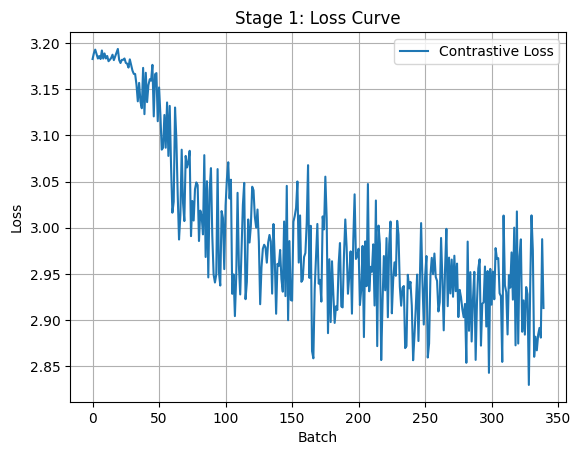

=== Stage 2: Language Model Pretraining ===
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240


Resolving data files:   0%|          | 0/804 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/151 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/133 [00:00<?, ?it/s]

Stage 2: Training 156,677,760 parameters


Stage2 Epoch 10: 100%|██████████| 34/34 [01:15<00:00,  2.23s/it]


Stage 2 completed!


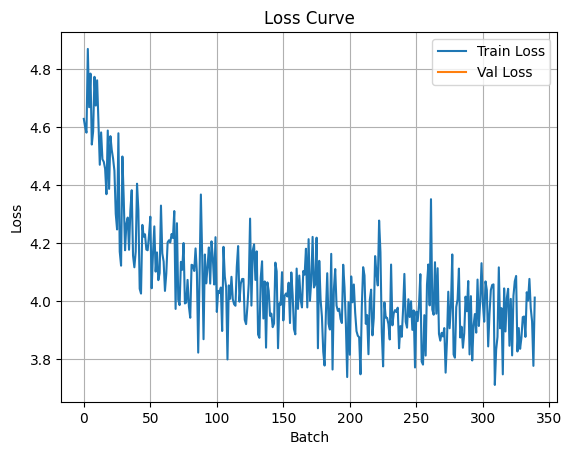

=== Stage 3: Instruction Tuning ===
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240


Resolving data files:   0%|          | 0/804 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/151 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/133 [00:00<?, ?it/s]

Stage 3: Training all 398,411,904 parameters


Stage3 Epoch 1:   3%|▎         | 1/34 [00:04<02:13,  4.04s/it]

Stage3 Step: 0, Instruction Loss: 4.3794


Stage3 Epoch 1: 100%|██████████| 34/34 [01:15<00:00,  2.22s/it]


Stage3 Epoch 1/5 | Instruction Loss: 3.9435


Stage3 Epoch 2:  50%|█████     | 17/34 [00:38<00:36,  2.15s/it]

Stage3 Step: 50, Instruction Loss: 4.0669


Stage3 Epoch 2: 100%|██████████| 34/34 [01:14<00:00,  2.20s/it]


Stage3 Epoch 2/5 | Instruction Loss: 3.9410


Stage3 Epoch 3:  97%|█████████▋| 33/34 [01:13<00:02,  2.14s/it]

Stage3 Step: 100, Instruction Loss: 3.7171


Stage3 Epoch 3: 100%|██████████| 34/34 [01:15<00:00,  2.23s/it]


Stage3 Epoch 3/5 | Instruction Loss: 3.9381


Stage3 Epoch 4: 100%|██████████| 34/34 [01:15<00:00,  2.23s/it]


Stage3 Epoch 4/5 | Instruction Loss: 3.9322


Stage3 Epoch 5:  44%|████▍     | 15/34 [00:35<00:41,  2.20s/it]

Stage3 Step: 150, Instruction Loss: 3.9365


Stage3 Epoch 5: 100%|██████████| 34/34 [01:16<00:00,  2.26s/it]


Stage3 Epoch 5/5 | Instruction Loss: 3.9316
Stage 3 completed!


In [ ]:
# ========== 选择模型大小和创建配置 ==========
# 由于遇到NaN问题，我们先用较小的模型调试
MODEL_SIZE = '135M'  # 先用最小的模型排除NaN问题

print(f"Using {MODEL_SIZE} language model...")

# 使用原始配置而不是enhanced配置，减少复杂性
alm_cfg = ALMConfig()
train_cfg = TrainConfig()

# 手动设置为135M配置
config_135m = get_model_config_by_size('135M')
for key, value in config_135m.items():
    setattr(alm_cfg, key, value)

# 极度保守的训练配置
train_cfg.lr_mp = 1e-6          # 降低学习率
train_cfg.lr_backbones = 5e-7   # 更小的学习率
train_cfg.batch_size = 4        # 减少batch size
train_cfg.data_cutoff_idx = 200 # 先用更少数据
train_cfg.stage1_epochs = 8     # 减少训练轮次
train_cfg.stage2_epochs = 6     # 减少训练轮次
train_cfg.stage3_epochs = 3     # 减少训练轮次

print(f"Model config: {alm_cfg.lm_model_type}")
print(f"Hidden dim: {alm_cfg.lm_hidden_dim}")
print(f"Batch size: {train_cfg.batch_size}")
print(f"Learning rates: MP={train_cfg.lr_mp}, Backbone={train_cfg.lr_backbones}")
print(f"Data cutoff: {train_cfg.data_cutoff_idx}")

# ========== 开始修复版训练 ==========

try:
    print("Starting CONSERVATIVE three-stage training to fix NaN issues...")
    
    # 第一阶段：模态对齐 (先确保这个阶段正常)
    print(f"\n🔄 Stage 1: Modality Alignment ({train_cfg.stage1_epochs} epochs)")
    stage1_model = train_step1_alignment(train_cfg, alm_cfg)
    
    # 检查Stage1模型是否有NaN
    if detect_nan_in_model(stage1_model, "Stage1 final: "):
        print("❌ Stage1 model has NaN! Stopping training.")
        raise ValueError("Stage1 model corrupted with NaN values")
    else:
        print("✅ Stage1 model is clean, no NaN detected")
    
    # 第二阶段：使用极度保守的训练方法
    print(f"\n🔄 Stage 2: ULTRA CONSERVATIVE Language Model Pretraining ({train_cfg.stage2_epochs} epochs)")
    stage2_model = ultra_conservative_train_step2(train_cfg, alm_cfg, stage1_model)
    
    # 检查Stage2模型是否有NaN
    if detect_nan_in_model(stage2_model, "Stage2 final: "):
        print("❌ Stage2 model has NaN! Stopping training.")
        raise ValueError("Stage2 model corrupted with NaN values")
    else:
        print("✅ Stage2 model is clean, no NaN detected")
    
    # 第三阶段：指令微调 (如果前两阶段都成功)
    print(f"\n🔄 Stage 3: Instruction Tuning ({train_cfg.stage3_epochs} epochs)")
    final_model = train_step3_instruction_tuning(train_cfg, alm_cfg, stage2_model)
    
    # 保存模型
    try:
        stage1_model.save_pretrained(f"/content/stage1_{MODEL_SIZE}_fixed")
        stage2_model.save_pretrained(f"/content/stage2_{MODEL_SIZE}_fixed")  
        final_model.save_pretrained(f"/content/final_{MODEL_SIZE}_fixed")
        print(f"✅ Training completed! Models saved with {MODEL_SIZE}_fixed suffix.")
    except Exception as save_error:
        print(f"❌ Error saving models: {save_error}")
    
    # 简单测试
    print("\n🧪 Testing final model integrity...")
    if detect_nan_in_model(final_model, "Final model: "):
        print("❌ Final model has NaN!")
    else:
        print("✅ Final model is clean!")
        
        # 简单的前向传播测试
        try:
            test_input = torch.randint(0, 1000, (1, 10)).to(final_model.device if hasattr(final_model, 'device') else 'cpu')
            test_audio = torch.randn(1, 1500, 768).to(final_model.device if hasattr(final_model, 'device') else 'cpu')
            
            with torch.no_grad():
                test_output = final_model(test_input, test_audio)
                if torch.isnan(test_output[0]).any():
                    print("❌ Model output contains NaN!")
                else:
                    print("✅ Model forward pass successful!")
        except Exception as test_error:
            print(f"❌ Model test failed: {test_error}")
    
except torch.cuda.OutOfMemoryError:
    print("❌ GPU memory error! Try reducing batch_size further.")
    print("Suggestions:")
    print("1. Reduce train_cfg.batch_size to 2 or 1")
    print("2. Reduce train_cfg.data_cutoff_idx to 100")
    
except Exception as e:
    print(f"❌ Training error: {e}")
    print("This might be due to:")
    print("1. NaN values in gradients (fixed by ultra_conservative training)")
    print("2. Learning rate too high (reduced to 1e-6)")
    print("3. Model architecture issues")
    print("4. Data preprocessing problems")
    
    # 提供调试信息
    import traceback
    print("\nFull traceback:")
    traceback.print_exc()

In [ ]:
# ========== 快速诊断NaN问题 ==========

def quick_diagnosis():
    """快速诊断训练数据和模型"""
    print("=== Quick Diagnosis for NaN Issues ===")
    
    # 创建最小配置用于测试
    alm_cfg = ALMConfig()
    train_cfg = TrainConfig()
    
    # 设置为135M
    config_135m = get_model_config_by_size('135M')
    for key, value in config_135m.items():
        setattr(alm_cfg, key, value)
    
    # 减少数据量
    train_cfg.data_cutoff_idx = 50
    train_cfg.batch_size = 2
    
    try:
        # 1. 测试数据加载
        print("1. Testing data loading...")
        train_loader, val_loader, test_loader = get_dataloaders(train_cfg, alm_cfg)
        
        # 获取一个batch
        batch = next(iter(train_loader))
        audios = batch["audio"]
        input_ids = batch["input_ids"]
        labels = batch["labels"]
        attention_mask = batch["attention_mask"]
        
        print(f"✅ Data loaded successfully")
        print(f"   Audio shape: {audios.shape}")
        print(f"   Input IDs shape: {input_ids.shape}")
        print(f"   Labels shape: {labels.shape}")
        
        # 检查数据中是否有NaN
        audio_nan = torch.isnan(audios).any()
        input_nan = torch.isnan(input_ids.float()).any()
        label_nan = torch.isnan(labels.float()).any()
        
        print(f"   Audio has NaN: {audio_nan}")
        print(f"   Input IDs has NaN: {input_nan}")
        print(f"   Labels has NaN: {label_nan}")
        
        if audio_nan or input_nan or label_nan:
            print("❌ Data contains NaN values!")
            return False
        
        # 2. 测试模型初始化
        print("\n2. Testing model initialization...")
        model = AudioLanguageModel(alm_cfg)
        
        if detect_nan_in_model(model, "Initial model: "):
            print("❌ Model initialized with NaN!")
            return False
        else:
            print("✅ Model initialized without NaN")
        
        # 3. 测试前向传播
        print("\n3. Testing forward pass...")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        audios = audios.to(device)
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        attention_mask = attention_mask.to(device)
        
        with torch.no_grad():
            try:
                logits, loss = model(input_ids, audios, attention_mask=attention_mask, targets=labels)
                
                print(f"✅ Forward pass successful")
                print(f"   Logits shape: {logits.shape}")
                print(f"   Loss: {loss.item():.6f}")
                
                # 检查输出
                if torch.isnan(logits).any():
                    print("❌ Logits contain NaN!")
                    return False
                if torch.isnan(loss):
                    print("❌ Loss is NaN!")
                    return False
                
                # 检查logits的数值范围
                print(f"   Logits range: [{logits.min().item():.3f}, {logits.max().item():.3f}]")
                if logits.max().item() > 100 or logits.min().item() < -100:
                    print("⚠️  Warning: Logits have extreme values!")
                
                print("✅ All checks passed!")
                return True
                
            except Exception as e:
                print(f"❌ Forward pass failed: {e}")
                return False
                
    except Exception as e:
        print(f"❌ Diagnosis failed: {e}")
        return False

# 运行诊断
print("Running quick diagnosis...")
diagnosis_result = quick_diagnosis()

if diagnosis_result:
    print("\n✅ Diagnosis passed! You can proceed with training.")
else:
    print("\n❌ Diagnosis failed! Please fix the issues before training.")
    print("Common fixes:")
    print("1. Check data preprocessing")
    print("2. Reduce learning rates further") 
    print("3. Use gradient clipping")
    print("4. Check model architecture")

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


As you can see the model trains, so feel free to play around with the architecture or data! Let us know what you build with it!

PS: If you want to test the model, check out generate.py to see how to do inference with it

### Test

In [18]:
!cp /content/drive/MyDrive/nanoALM/output_txt1.wav /content/output_txt1.wav
!cp /content/drive/MyDrive/nanoALM/output_txt2.wav /content/output_txt2.wav
!cp /content/drive/MyDrive/nanoALM/output_txt3.wav /content/output_txt3.wav

cp: cannot stat '/content/drive/MyDrive/nanoALM/output_txt1.wav': No such file or directory
cp: cannot stat '/content/drive/MyDrive/nanoALM/output_txt2.wav': No such file or directory
cp: cannot stat '/content/drive/MyDrive/nanoALM/output_txt3.wav': No such file or directory


In [ ]:
# final_model.save_pretrained("/content/")
!python generate.py --checkpoint ../ --audio ../output_txt3.wav --prompt hellp

2025-06-26 09:41:04.303692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750930864.324349   76262 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750930864.330436   76262 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using device: cuda
Loading weights from: ../
AudioProcessor_from_HF initialized with model: <class 'transformers.models.whisper.processing_whisper.WhisperProcessor'>
  Target feature frames from cfg: 1500
  Using model sampling rate: 16000, hop_length: 160, n_fft: 400
  Calculated max raw audio samples for processor: 240240

Input:
  hellp 

Outputs:
  >> Generation 1: 11111111111111111111111111111111111111111111111111111111111111111